In [15]:
from on_request_pipeline import get_request
from connection_functions import set_alert, get_historical_data_mock, send_alert, get_alert, delete_alert
from dataprocessing_functions import check_custom_alerts
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import threading

In [16]:
fields = [
    "time",
    "asset_id",
    "name",
    "kpi",
    "operation",
    "sum",
    "avg",
    "min",
    "max",
    "var",
]
identity = ["asset_id", "name", "kpi", "operation"]
features = ["sum", "avg", "min", "max", "var"]
b_length = 40
faulty_aq_tol = 3

machines = {
    "Large Capacity Cutting Machine 1": "ast-yhccl1zjue2t",
    "Medium Capacity Cutting Machine 1": "ast-ha448od5d6bd",
    "Large Capacity Cutting Machine 2": "ast-6votor3o4i9l",
    "Medium Capacity Cutting Machine 2": "ast-5aggxyk5hb36",
    "Medium Capacity Cutting Machine 3": "ast-anxkweo01vv2",
    "Low Capacity Cutting Machine 1": "ast-6nv7viesiao7",
    "Laser Cutter": "ast-xpimckaf3dlf",
    "Laser Welding Machine 1": "ast-hnsa8phk2nay",
    "Laser Welding Machine 2": "ast-206phi0b9v6p",
    "Assembly Machine 1": "ast-pwpbba0ewprp",
    "Assembly Machine 2": "ast-upqd50xg79ir",
    "Assembly Machine 3": "ast-sfio4727eub0",
    "Testing Machine 1": "ast-nrd4vl07sffd",
    "Testing Machine 2": "ast-pu7dfrxjf2ms",
    "Testing Machine 3": "ast-06kbod797nnp",
    "Riveting Machine": "ast-o8xtn5xa8y87",
}

# Test for Costumed Alerts 

Simulation of the submission of a new alert (request from the GUI)

In [17]:
#Selection from user
machine_name = "Large Capacity Cutting Machine 1"
asset_id = "ast-yhccl1zjue2t"
kpi = "time"
operation = "idle"

In [18]:
#Selection from user
thresholds = {
    "max_threshold": 15000,
    "max_days_tolerance": 2,
    "min_threshold": None,
    "min_days_tolerance": None
}

response = set_alert(machine_name, asset_id, kpi, operation, thresholds)
print(response)

Alert configuration set for machine 'Large Capacity Cutting Machine 1' (asset_id=ast-yhccl1zjue2t, kpi=time, operation=idle)


Prototype of functioning on a simplified version of the streaming pipeline. To change the email go to config.py and set the recipient_email with your own.

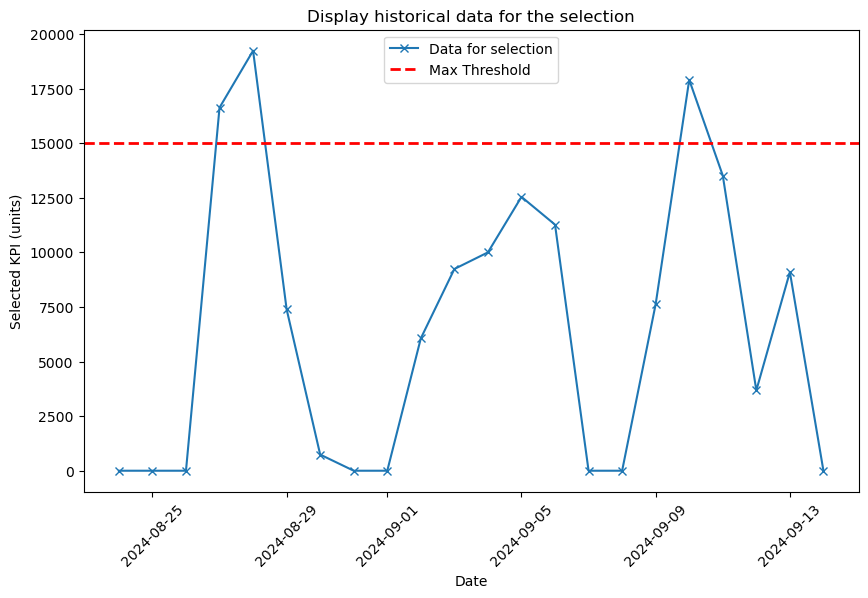

In [19]:
# For simplicity we simulate the arrival of data for a single machine (the one that has the custom alert)

timestamp_start = "2024-08-24 00:00:00+00:00"
timestamp_end = "2024-09-14 00:00:00+00:00"
historical_data = get_historical_data_mock(
            machine_name, asset_id, kpi, operation, timestamp_start, timestamp_end)

# Ensure the 'time' columns in all DataFrames are datetime
historical_data['time'] = pd.to_datetime(historical_data['time'])

# We plot the graph and the max_threshold for visualization pourposes
plt.figure(figsize=(10, 6))
plt.plot(
    historical_data['time'],
    historical_data['avg'],
    marker='x',
    label='Data for selection'
)
plt.axhline(y=thresholds["max_threshold"], color='red', linestyle='dashed', linewidth=2, label='Max Threshold')
plt.title('Display historical data for the selection')
plt.xlabel('Date')
plt.ylabel('Selected KPI (units)') 
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()


In [20]:
# OBSERVE THAT THERE ARE 3 VALUES ABOVE THE THRESHOLD, BUT ONLY ONE OF THEM GOES OVER THE TOLERANCE AMUNT OF DAYS
# SO ONLY ONE ALERT WILL BE SENT

# Then we use that data in the streaming pipeline to send emails if some values goes over the thresholds
c = 0

while c < 22:
    
    new_datapoint = historical_data.iloc[c].to_dict()

    # in this case data is already clean
    #cleaned_datapoint = cleaning_pipeline(new_datapoint)
    cleaned_datapoint = new_datapoint

    if cleaned_datapoint:
        # normally we first check for drift
        # then we check if the point is anomalous and send an alert in case
        
        ### This is the new part of the code
        
        #Check for customed alerts
        crossed_thresholds = check_custom_alerts(cleaned_datapoint)
        if crossed_thresholds is not None:

            customed_alert_identity = {key: cleaned_datapoint[key] for key in identity if key in cleaned_datapoint}

            customed_alert_identity['explanation'] = "The customed alert was triggered because the machine has \
            produced values " + crossed_thresholds['type'] + " threshold set by the user (being it = " + \
                str(crossed_thresholds["threshold_value"]) + ") for " + str(crossed_thresholds["days_counted"]) + " consecutive days."
            
            if crossed_thresholds["days_tolerance"] is not None:

                customed_alert_identity['explanation'] += "The tolerance for days " + crossed_thresholds['type'] + " was of "+\
                str(crossed_thresholds["days_tolerance"]) + " consecutive days."
                
            send_alert(customed_alert_identity, 'Customed Alert', None, None)
            
    # in this case we don't store the datapoint
    # store_datapoint(cleaned_datapoint)  
    c += 1


Email sent successfully!


Simulation of the deletion of an alert (request from GUI)

In [21]:
# This function retrieve the thresholds set for the alert, in case they exist (if not return None)
thresholds_of_alert = get_alert(machine_name, asset_id, kpi, operation)
print(thresholds_of_alert)

{'max_threshold': 15000, 'max_days_tolerance': 2, 'min_threshold': None, 'min_days_tolerance': None, 'above_count': 0, 'below_count': 0}


In [22]:
# This function delete the alert
response = delete_alert(machine_name, asset_id, kpi, operation)
print(response)

Alert for machine 'Large Capacity Cutting Machine 1' (asset_id=ast-yhccl1zjue2t, kpi=time, operation=idle) deleted.


# Test for Retraining in Threading

We already shown the functioning of the drift algorithm and of the retraining and updating of the models, so in this part we will only show that the separation in threads allows the algorithm to go on with the processing of data while other operations are performed in a different thread.

In [23]:
# This is simplified version of the function that holds the retraing and updating of the model when some drift is detected
# the arguments datapoint_number and thread_id are used for visualization purposes, but are not part of the real function

def retrain_models_after_drift(cleaned_datapoint, datapoint_number, thread_id):
    """
    This function retrieves historical data and retrains:
      - Anomaly detection
      - LIME explainer
      - Forecasting models
    """
    print(f"[TRAINING THREAD {thread_id}] Detected DRIFT at DataPoint {datapoint_number}. Retraining models...")

    # Normally we retrieve historical data to use it for the training

    # Then we retrain anomaly detection model

    # Then we retrain LIME explainer

    # Then we retrain forecasting models for each feature

    # In this case we simulate the retraining by waiting for 5 seconds
    time.sleep(5)

    print(f"[TRAINING THREAD {thread_id}] Training completed for DataPoint {datapoint_number}.")


In [24]:
# We use the same historical data that we retrieved before

c = 0
thread_counter = 1  # To track unique thread IDs

while c < 22:
    time.sleep(2)  # Simulate the arrival of data every 2 seconds

    new_datapoint = historical_data.iloc[c].to_dict()

    # in this case data is already clean
    cleaned_datapoint = new_datapoint

    if cleaned_datapoint:
        # Normally we first check for drift

        # If drift is detected, we start retraining the models on a different thread
        # Here, we simulate drift detection when 'avg' > 15000

        if cleaned_datapoint['avg'] > 15000:

            t = threading.Thread(target=retrain_models_after_drift, args=(cleaned_datapoint, c + 1, thread_counter))
            t.start()
            thread_counter += 1  # Increment thread counter

        # Then we check if the point is anomalous and send an alert in case

        # Then we check for custom alerts and send an alert in case

    # In this case we don't store the datapoint
    # store_datapoint(cleaned_datapoint)  
    print(f"[MAIN] DataPoint {c + 1} has been processed.")

    c += 1


[MAIN] DataPoint 1 has been processed.
[MAIN] DataPoint 2 has been processed.
[MAIN] DataPoint 3 has been processed.
[TRAINING THREAD 1] Detected DRIFT at DataPoint 4. Retraining models...
[MAIN] DataPoint 4 has been processed.
[TRAINING THREAD 2] Detected DRIFT at DataPoint 5. Retraining models...[MAIN] DataPoint 5 has been processed.

[MAIN] DataPoint 6 has been processed.
[TRAINING THREAD 1] Training completed for DataPoint 4.
[MAIN] DataPoint 7 has been processed.
[TRAINING THREAD 2] Training completed for DataPoint 5.
[MAIN] DataPoint 8 has been processed.
[MAIN] DataPoint 9 has been processed.
[MAIN] DataPoint 10 has been processed.
[MAIN] DataPoint 11 has been processed.
[MAIN] DataPoint 12 has been processed.
[MAIN] DataPoint 13 has been processed.
[MAIN] DataPoint 14 has been processed.
[MAIN] DataPoint 15 has been processed.
[MAIN] DataPoint 16 has been processed.
[MAIN] DataPoint 17 has been processed.
[TRAINING THREAD 3] Detected DRIFT at DataPoint 18. Retraining models...


# Test for Advanced Data Analysis - Trend and SEasonality

Simulation of requests coming from the GUI

In [25]:
message_seasonality, transformed_data_seasonality = get_request(
    "Large Capacity Cutting Machine 1",
    "ast-yhccl1zjue2t",
    "time",
    "idle",
    "2024-08-24 00:00:00+00:00",
    "2024-09-14 00:00:00+00:00",
    "S"
)


message_trend, transformed_data_trend = get_request(
    "Large Capacity Cutting Machine 1",
    "ast-yhccl1zjue2t",
    "time",
    "idle",
    "2024-08-24 00:00:00+00:00",
    "2024-09-14 00:00:00+00:00",
    "T"
)


c:\Users\auran\anaconda3\envs\Torch\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\auran\anaconda3\envs\Torch\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\auran\anaconda3\envs\Torch\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\auran\anaconda3\envs\Torch\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\auran\anaconda3\envs\Torch\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\auran\anaconda3\envs\Torch\Lib\site-packages\statsmodels\tsa\holtw

Simulations of the displayed graphics. Note that the information of units of measurement of the selected features was not added in this simulation. Such information can be extracted by the GUI using the taxonomy or also as additional information by the Data Processing engine implementing those connections with the Taxonomy in a future work.

Generating the plot for the seasonality request:

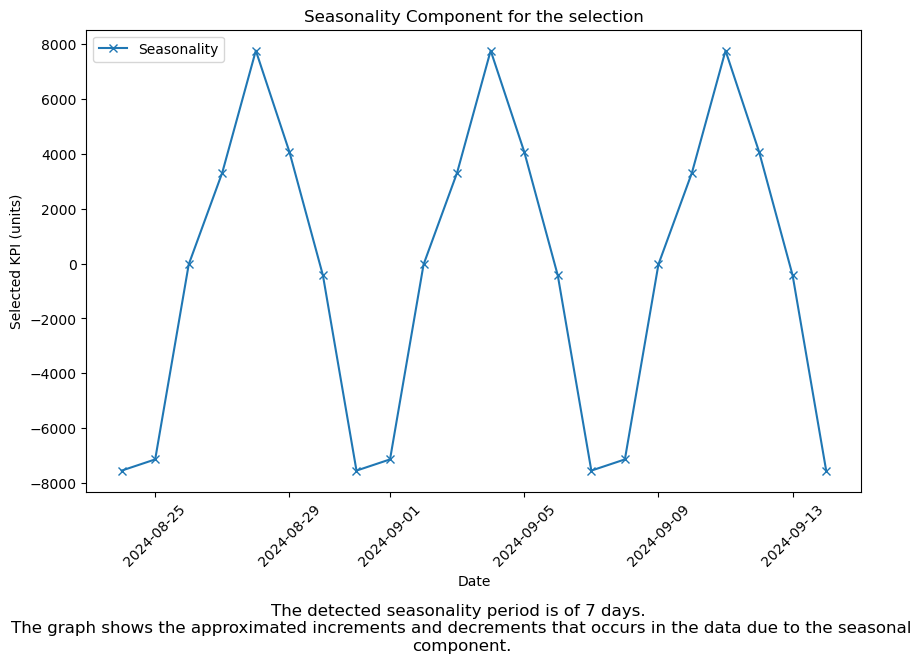

In [26]:
# Ensure the 'time' columns in all DataFrames are datetime
transformed_data_seasonality['time'] = pd.to_datetime(transformed_data_seasonality['time'])

# Plot Seasonality Component
plt.figure(figsize=(10, 6))
plt.plot(
    transformed_data_seasonality['time'],
    transformed_data_seasonality['avg'],
    marker='x',
    label='Seasonality'
)
plt.title('Seasonality Component for the selection')
plt.xlabel('Date')
plt.ylabel('Selected KPI (units)') 
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.figtext(0.5, -0.15, message_seasonality, 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()


Generating the plot for the trend request:

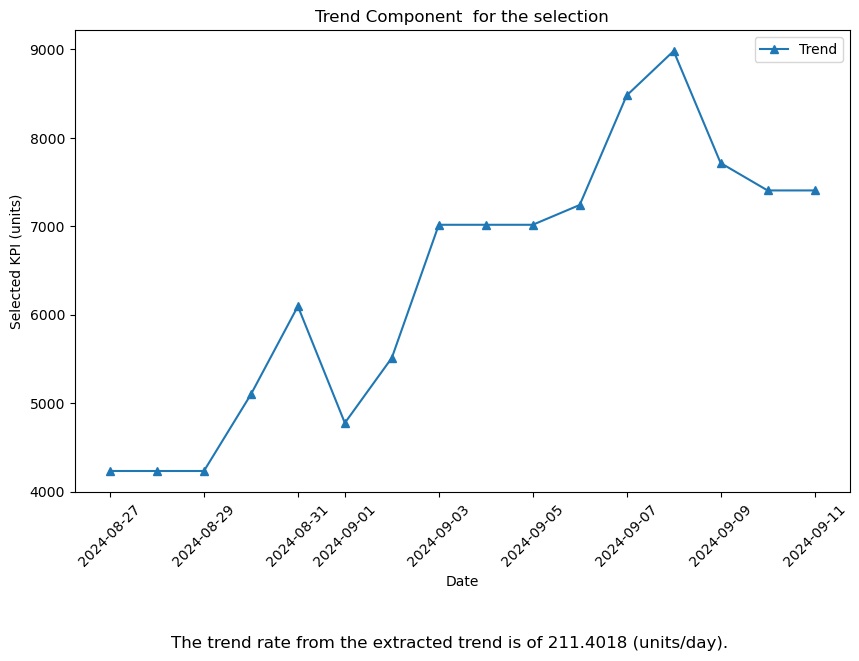

In [27]:
transformed_data_trend['time'] = pd.to_datetime(transformed_data_trend['time'])

# Plot Trend Component
plt.figure(figsize=(10, 6))
plt.plot(
    transformed_data_trend['time'],
    transformed_data_trend['avg'],
    marker='^',
    label='Trend'
)
plt.title('Trend Component  for the selection')
plt.xlabel('Date')
plt.ylabel('Selected KPI (units)') 
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.figtext(0.5, - 0.15, message_trend, 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()
